In [1]:
import plyvel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from pyquery import PyQuery

from IPython.display import Markdown, display

def md(text):
    display(Markdown(text))

In [2]:
db = plyvel.DB("events.leveldb.db")

In [3]:
TYPES = {
    "content-edit": (" hat eine neue Version von ", " erstellt"),
    "content-associate": (" hat ", " assoziiert - "),
    "content-delete": (" hat ", " entfernt - "),
    "content-connect": (" hat ", " verknüpft - "),
    "content-update": (" hat ", " aktualisiert - "),
    "content-move": (" hat ", " verschoben - "),
    "content-archive": (" hat ", " archiviert - "),
    "content-recreated": (" hat ", " wiederhergestellt"),
    "content-create": (" hat ", " erstellt"),
    "review-approved": (" hat ", " ausgecheckt"),
    "review-disapproved": (" hat ", " abgelehnt"),
    "term-create": (" hat den Elter des Begriffs ", " geändert"),
    "comment": (" hat ", " kommentiert"),
    "template-notfound": ("Es wurde kein template für "),
    "license-change": (" hat die Lizenz von ", " geändert - "),
}

def convert(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, event_base_type, event_type)
    
data = [convert(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data.sort(key=lambda x: x[0])
data = pd.DataFrame(data, columns=["time", "author", "event_base", "event"])
data.index = data["time"]

In [4]:
data["event"] = data["event"].astype("category")
data["event_base"] = data["event_base"].astype("category")

In [5]:
data_no_legacy = data[data["author"] != "Legacy"]
data_edit = data_no_legacy[data_no_legacy["event"] == "content-edit"]

## Verlauf Anzahl aller Events pro Woche

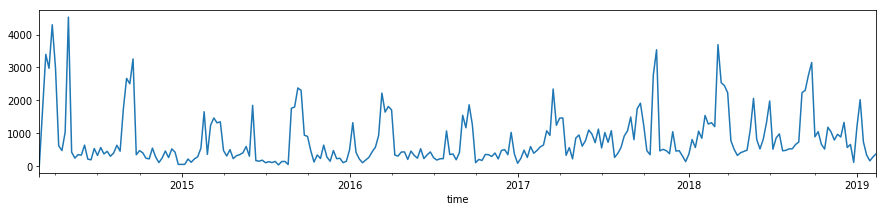

In [6]:
md("## Verlauf Anzahl aller Events pro Woche")
data_no_legacy.resample("W")["author"].count().plot(figsize=(15,3))

In [7]:
md("## Übersicht aller Events")
data_no_legacy["author"].describe()

## Übersicht aller Events

count     208580
unique       888
top       Renate
freq       12826
Name: author, dtype: object

## Verteilung der verschiedenen Arten von Events

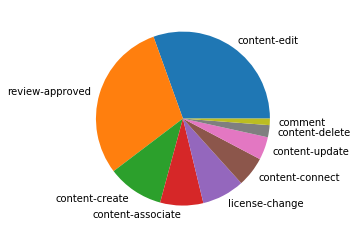

content-edit          62555
review-approved       61205
content-create        21443
content-associate     16418
license-change        16222
content-connect       11469
content-update         8749
content-delete         4609
comment                2475
content-move           1891
term-create             591
content-archive         423
template-notfound       376
review-disapproved      325
content-recreated       205
Name: event, dtype: int64

In [8]:
md("## Verteilung der verschiedenen Arten von Events")
data_no_legacy["event"].value_counts().head(9).plot(kind="pie")
plt.ylabel("")
plt.show()
data_no_legacy["event"].value_counts()

## Anzahl Events pro Jahr

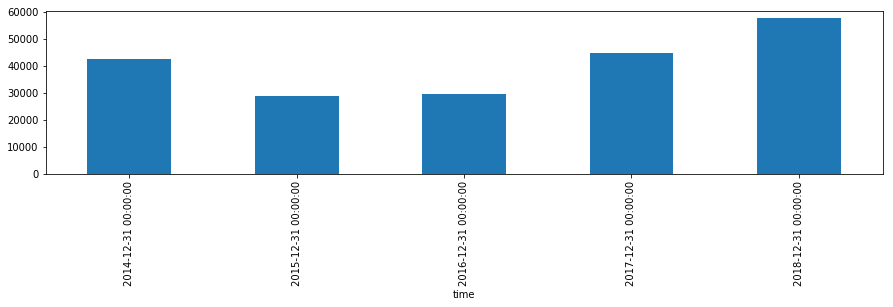

In [9]:
md("## Anzahl Events pro Jahr")
data_no_legacy.resample("Y")["author"].count()[:-1].plot(figsize=(15,3), kind="bar")

## Trends in der Anzahl der Events

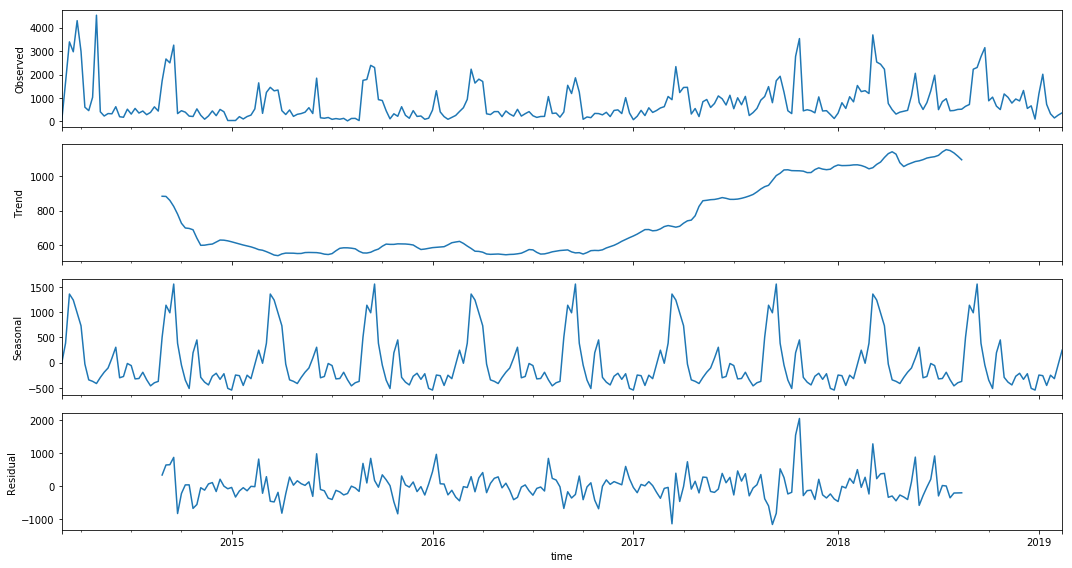

In [11]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_no_legacy.resample("W").count()["time"], model="additive")
md("## Trends in der Anzahl der Events")
dec.plot()
plt.show()

## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)

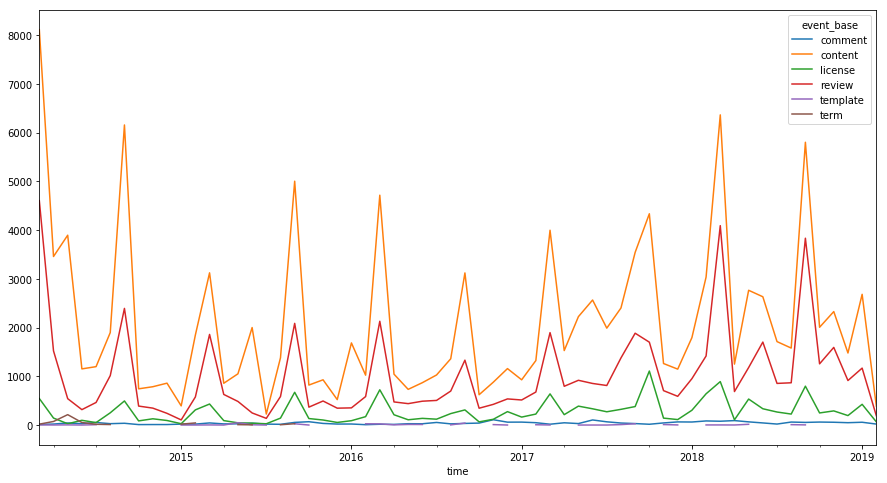

In [12]:
md("## Monatlicher Verlauf der verschiedenen Events (sortiert nach Typ)")
data_no_legacy.resample("M")["event_base"].value_counts().unstack().plot()

In [13]:
md("## 20 Top-Autorinnen (Alle-Events)")
data_no_legacy.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Alle-Events)

author
Renate           12826
Nish              9622
chdieter          7117
Simon             6192
metzgaria         5737
kazuki            4934
Knorrke           4603
Kati_L            4316
Rebi              3890
Jonathan          3815
LeaFa             3567
Katha26           3543
Hannes            3400
Lena09            3260
Tinsaye           3217
tobi_serlo        3174
NiCi              3129
wolfgang          2561
Marvin            2559
adrian_wagner     2488
Name: event, dtype: int64

In [14]:
md("## 20 Top-Autorinnen (Nur Bearbeitungen)")
data_edit.groupby("author").count()["event"].sort_values(ascending=False).head(20)

## 20 Top-Autorinnen (Nur Bearbeitungen)

author
chdieter         2454
Nish             2304
Simon            1949
Renate           1788
Jonathan         1388
metzgaria        1333
Kati_L           1318
kazuki           1181
Knorrke          1106
LeaFa            1072
Lena09            933
Rebi              910
Tinsaye           894
adrian_wagner     874
Katha26           848
tobi_serlo        847
Niggo             810
haberlm           804
Karin             749
Manuel_Voigt      747
Name: event, dtype: int64

## Verlauf wöchentliche Anzahl Bearbeitungen

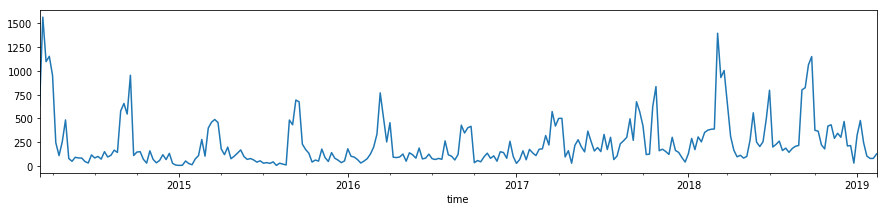

In [15]:
md("## Verlauf wöchentliche Anzahl Bearbeitungen")
data_edit.resample("W")["author"].count().plot(figsize=(15,3))

## Trend wöchentliche Bearbeitungen

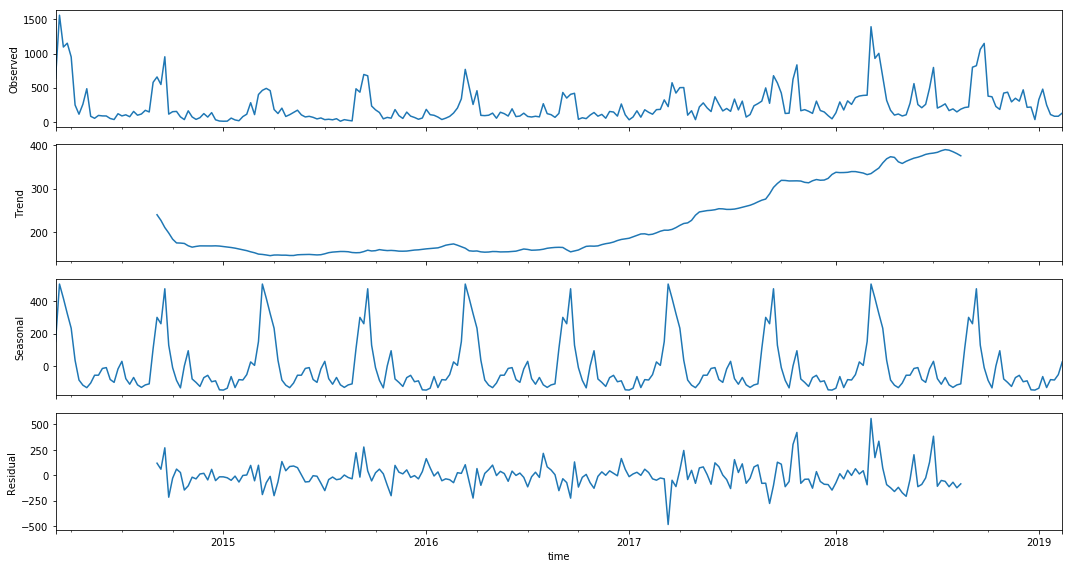

In [16]:
plt.rcParams["figure.figsize"] = (15,8)
dec = sm.tsa.seasonal_decompose(data_edit.resample("W").count()["time"], model="additive")
md("## Trend wöchentliche Bearbeitungen")
dec.plot()
plt.show()

In [17]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle aktive Autor*innen")
md("Anzahl: %s" % a[a > 10].count())
a[a > 10]

## Aktuelle aktive Autor*innen

Anzahl: 42

author
Alex_Lueckenhaus      37
Daniel-I              91
Daphne_s              14
Felix96               28
Greta                 36
Jojuacamole           80
Jonathan            1647
Karin                171
Karin2406             48
Kati_L               230
Knorrke               53
Kowalsky              29
Kulla                 20
Laura                 43
Leo1                  55
Maria_F              111
Martin_Gast           54
Michi_pi              11
Nish                  97
Quatematik            59
Renate                43
Ronnit                29
Schneeeule            35
Simon                 38
Simone_Heinrich      304
ThomasBrunner        139
Valentin01           142
abcd                  14
botho                 15
chdieter             116
darja_wlhlm          119
hernlmax             135
inyono                53
kathongi             170
laraamann             26
markus_janker        180
max25                156
metzgaria             87
moritz0312           556
opamp             

## Verlauf aktive Autor*innen

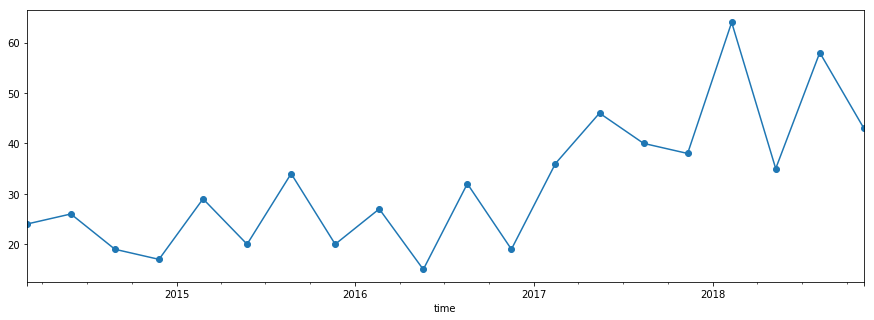

In [19]:
md("## Verlauf aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 10].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [20]:
last90 = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-90 days"))

a = last90[last90["event_base"] == "content"].groupby("author")["time"].count()

md("## Aktuelle sehr aktive Autor*innen")
md("Anzahl: %s" % a[a > 100].count())
a[a > 100]

## Aktuelle sehr aktive Autor*innen

Anzahl: 14

author
Jonathan           1647
Karin               171
Kati_L              230
Maria_F             111
Simone_Heinrich     304
ThomasBrunner       139
Valentin01          142
chdieter            116
darja_wlhlm         119
hernlmax            135
kathongi            170
markus_janker       180
max25               156
moritz0312          556
Name: time, dtype: int64

## Verlauf sehr aktive Autor*innen

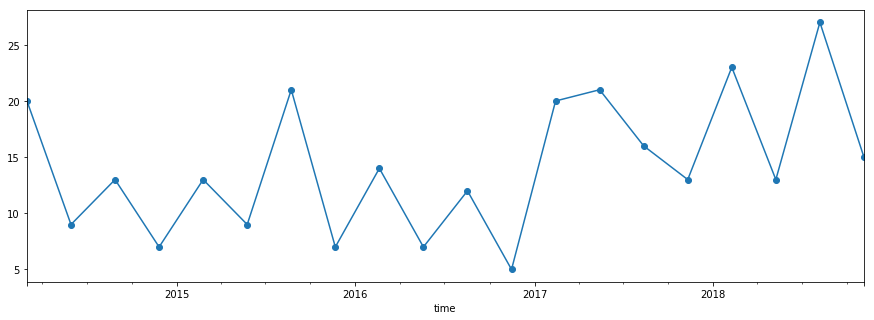

In [21]:
md("## Verlauf sehr aktive Autor*innen")
a = data_no_legacy[data_no_legacy["event_base"] == "content"].resample("90D")["author"].value_counts()
a[a[:,:] > 100].count("time")[:-1].plot(marker="o", figsize=(15,5))

In [22]:
md("## Langfristige Autor*innen")
last = data.truncate(before=pd.Timestamp.now() + pd.Timedelta("-270 days")).resample("90D")
a = last["author"].value_counts()[:-1]
p = a[a[:,:] > 10].unstack().transpose().dropna()

md("Anzahl: %s" % len(p))
p

## Langfristige Autor*innen

Anzahl: 14

time,2018-05-23 00:00:00,2018-08-21 00:00:00,2018-11-19 00:00:00
author,,,
Nish,867.0,665.0,235.0
metzgaria,693.0,364.0,208.0
wolfgang,581.0,365.0,34.0
Renate,556.0,514.0,91.0
Karin,464.0,444.0,315.0
kathongi,275.0,254.0,243.0
tobi_serlo,187.0,627.0,50.0
chdieter,150.0,591.0,227.0
Ronnit,113.0,245.0,52.0


In [ ]:
from itertools import count

def convert2(event):
    event = PyQuery(event.decode("utf-8"))
    event_text = event.text()
    
    event_timestamp = np.datetime64(event("abbr").text())
    event_type = None
    
    for k, v in TYPES.items():
        if all([x in event_text for x in v]):
            event_type = k
            break
        
    if not event_type:
        raise ValueError("TYPE NOT FOUND: " + event_text)
    
    links = [None, None, None]
    names = [None, None, None]
    types = ["X", "Y", "Z"]
    i = 0
    
    relation = ""
    
    for child in event.contents():
        if isinstance(child, str):
            child = child.strip()
            
            if child:
                relation += child
        else:
            if child.tag == "a":
                links[i] = child.get("href")
                names[i] = child.text
                relation += " %s " % types[i]
                
                i += 1
    
    if event_type != "template-notfound":
        event_author = event("a")[0].text
    else:
        event_author = None
        
    event_base_type = event_type.split("-")[0]
    
    return (event_timestamp, event_author, relation.strip(), event_base_type, event_type, links[0], names[0], links[1], names[1], links[2], names[2])

convert2(next(db.iterator(start=b"events-html", stop=b"events-html\xff"))[1])

data2 = [convert2(e) for (_, e) in db.iterator(start=b"events-html", stop=b"events-html\xff")]
data2.sort(key=lambda x: x[0])
data2 = pd.DataFrame(data, columns=["time", "author", "relation", "event_base", "event", "link_X", "value_X", "link_Y", "value_Y", "link_Z", "value_Z"])
data2.index = data["time"]
data2.to_csv("serlo-events.csv")